In [6]:
import os
import sys
sys.path.append('../../..')

import cv2
import copy
import numpy as np

%load_ext autoreload
%autoreload 2

from computer_vision.yolov11.modules.detector import DetectionModel
from computer_vision.yolov11.parameter_parser import parser
from computer_vision.yolov11.utils.check import check_imgsz
from computer_vision.yolov11.data.dataset import YOLODataset
from computer_vision.misc import alpha_bending
from computer_vision.yolov11.misc import instance2mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dirpath=r'D:/data/ultralytics/coco128-seg'

argument=f'''--root {data_dirpath} --image-dirname images/train2017 --label-dirname labels/train2017
--data-cfg ../coco128-seg.yaml --hyperparam ../default.yaml '''
args=parser.parse_args(argument.split())

model=DetectionModel(cfg='../yolo11.yaml', ch=3)
print('stride ', model.stride)
gs = max(int(model.stride.max() if hasattr(model, "stride") else 32), 32)  # grid size (max stride)
print('grid size ', gs)
check_imgsz(args.imgsz, stride=gs, floor=gs, max_dim=1) # args.imgsz 

dataset=YOLODataset(img_path=os.path.join(args.root, args.image_dirname),label_path=os.path.join(args.root, args.label_dirname),
                    data=args.data_cfg, hyp=args.hyperparam, imgsz=640, cache=True, augment=True, rect=False, batch_size=8, stride=32, pad=0.5, 
                    single_cls=False, classes=None, fraction=1., channels=3)

print('dataset.im_files ', len(dataset.im_files))

In BaseModel._predict_once max_idx -1 embed {-1}
stride  tensor([ 8., 16., 32.])
grid size  32
In data.dataset.YOLODataset.update_images_labels cache path D:\data\ultralytics\coco128-seg\labels\train2017.cache exist. Load it!!!
Scanning D:\data\ultralytics\coco128-seg\labels\train2017.cache ... 126 images with 2 missing and 0 empty files as well as 0 corrupt files
max_buffer_length  64  ni  128
dataset.im_files  128


In [4]:
from __future__ import annotations

import random
from typing import Any

import numpy as np

from computer_vision.yolov11.instance.instance import Instances
from computer_vision.yolov11.data.augment import CopyPaste, Mosaic, LetterBox
from computer_vision.yolov11.utils.ops import xywhn2xyxy, xywh2xyxy
from computer_vision.yolov11.data.utils import imread


from matplotlib import patches
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

### Flip

Main label-> bboxes.format  xywh  normalized  True
img  (416, 640, 3) height 416, width 640


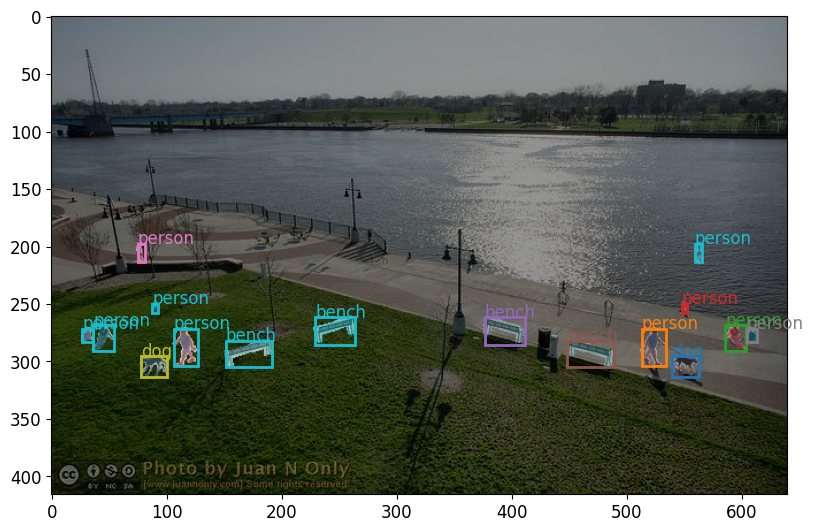

In [7]:
labels=dataset.get_image_and_label(index=20) # 90, 10
print('Main label-> bboxes.format ', labels['instances']._bboxes.format, ' normalized ', labels['instances'].normalized)

copypaste=CopyPaste(dataset=dataset, pre_transform=None, p=1, mode='flip')
final_labels=copypaste(labels)

_, ax=plt.subplots(figsize=(8,8))
classes=[dataset.data['names'][int(c)] for c in final_labels['cls'].flatten()]
img=final_labels['img']
height, width=img.shape[:2]
print('img ', img.shape, f'height {height}, width {width}')
boxes=np.copy(final_labels['instances'].bboxes) if not final_labels['instances'].normalized else xywh2xyxy(np.copy(final_labels['instances'].bboxes) )

mask=instance2mask(image=img, instance=final_labels['instances'])
ax.imshow(alpha_bending(mask, img[...,::-1], 0.4))
for j, (box,cls) in enumerate(zip(boxes, classes)):
    # Create a Rectangle patch
    rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(*box[:2], f'{cls}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)


### MixUp

Main label-> bboxes.format  xywh  normalized  True
Main label after letterbox-> bboxes.format  xyxy  normalized  False
In data.dataset.load_image self.buffer 3
img  (640, 640, 3) height 640, width 640


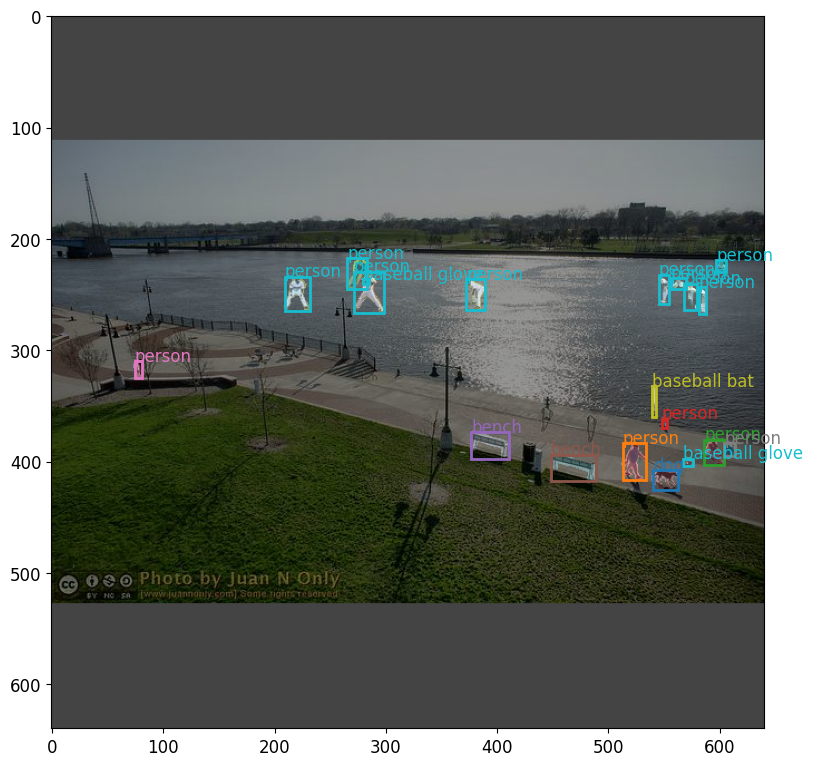

In [9]:
labels=dataset.get_image_and_label(index=20) # 90, 10
print('Main label-> bboxes.format ', labels['instances']._bboxes.format, ' normalized ', labels['instances'].normalized)

# To use `mixup`, we need to make two images having the same size 
pre_transform=LetterBox(new_shape=(dataset.imgsz, dataset.imgsz), scaleup=False)
labels=pre_transform(labels)
print('Main label after letterbox-> bboxes.format ', labels['instances']._bboxes.format, ' normalized ', labels['instances'].normalized)

copypaste=CopyPaste(dataset=dataset, pre_transform=pre_transform, p=1, mode='mixup')
final_labels=copypaste(labels)

_, ax=plt.subplots(figsize=(8,8))
classes=[dataset.data['names'][int(c)] for c in final_labels['cls'].flatten()]
img=final_labels['img']
height, width=img.shape[:2]
print('img ', img.shape, f'height {height}, width {width}')
boxes=np.copy(final_labels['instances'].bboxes) if not final_labels['instances'].normalized else xywh2xyxy(np.copy(final_labels['instances'].bboxes) )

mask=instance2mask(image=img, instance=final_labels['instances'])
ax.imshow(alpha_bending(mask, img[...,::-1], 0.4))
for j, (box,cls) in enumerate(zip(boxes, classes)):
    # Create a Rectangle patch
    rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(*box[:2], f'{cls}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)


# 